<a href="https://colab.research.google.com/github/omelyanchukfit6/Colab/blob/main/7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.5 MB/s eta 0:00:00


100%|██████████| 9.91M/9.91M [00:00<00:00, 41.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.10MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.27MB/s]


Epoch 1/10, Loss: 0.0518
Epoch 2/10, Loss: 0.0152
Epoch 3/10, Loss: 0.0144
Epoch 4/10, Loss: 0.0140
Epoch 5/10, Loss: 0.0138
Epoch 6/10, Loss: 0.0136
Epoch 7/10, Loss: 0.0134
Epoch 8/10, Loss: 0.0133
Epoch 9/10, Loss: 0.0132
Epoch 10/10, Loss: 0.0131


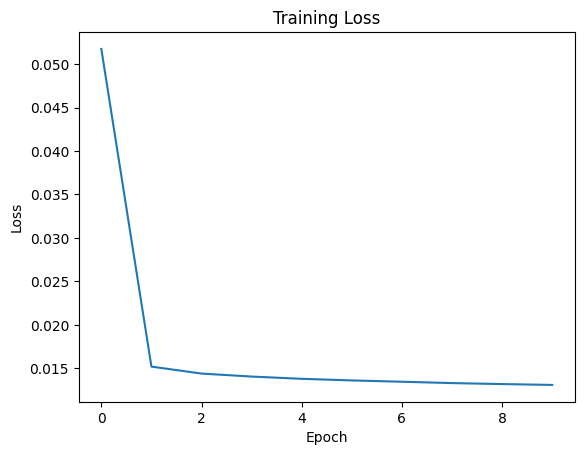

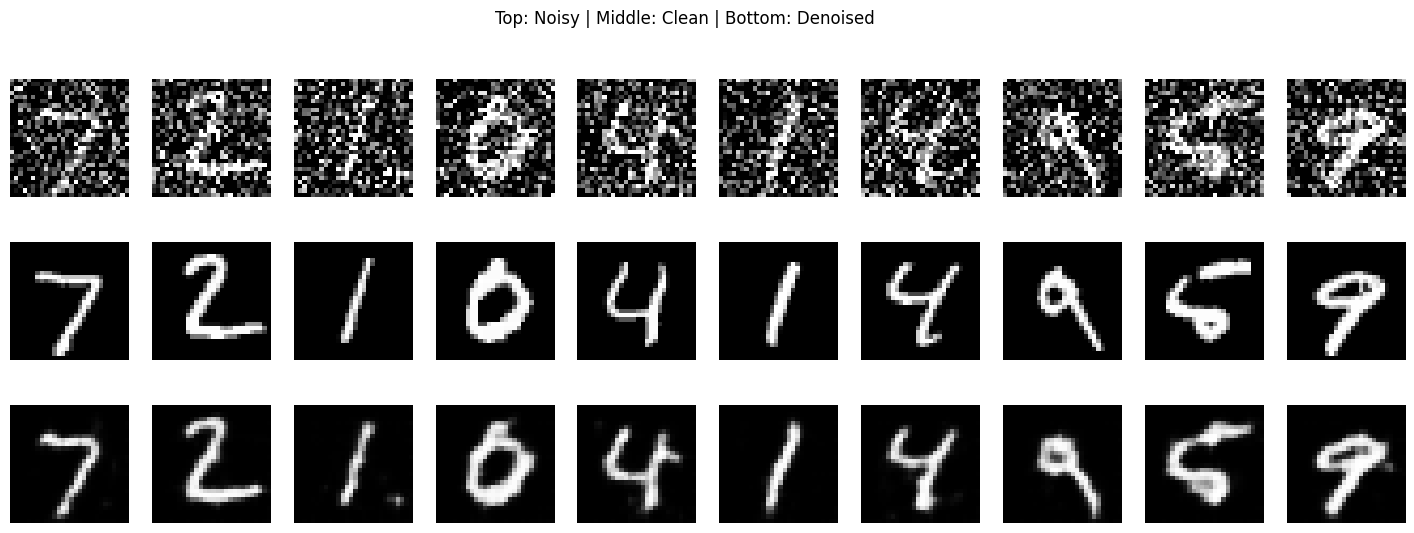

In [ ]:
!pip install torch torchvision matplotlib --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# MARK: - Parameters
BATCH_SIZE = 128
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MARK: - Dataset with noise
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def add_noise(img, noise_factor=0.5):
    noisy = img + noise_factor * torch.randn_like(img)
    return torch.clip(noisy, 0., 1.)

class NoisyMNIST(torch.utils.data.Dataset):
    def __init__(self, dataset, noise_factor=0.5):
        self.dataset = dataset
        self.noise_factor = noise_factor
    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        noisy_img = add_noise(img, self.noise_factor)
        return noisy_img, img
    def __len__(self):
        return len(self.dataset)

train_noisy = NoisyMNIST(train_dataset)
test_noisy  = NoisyMNIST(test_dataset)
train_loader = DataLoader(train_noisy, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_noisy, batch_size=BATCH_SIZE, shuffle=False)

# MARK: - Model
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1, padding=1), nn.Sigmoid(),
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# MARK: - Training
losses = []
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(DEVICE), clean_imgs.to(DEVICE)
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

# MARK: - Loss plot
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# MARK: - Results visualization
model.eval()
with torch.no_grad():
    noisy_imgs, clean_imgs = next(iter(test_loader))
    noisy_imgs, clean_imgs = noisy_imgs.to(DEVICE), clean_imgs.to(DEVICE)
    outputs = model(noisy_imgs)

def show_images(noisy, clean, output, n=10):
    plt.figure(figsize=(18, 6))
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(noisy[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
        plt.subplot(3, n, n+i+1)
        plt.imshow(clean[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
        plt.subplot(3, n, 2*n+i+1)
        plt.imshow(output[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle('Top: Noisy | Middle: Clean | Bottom: Denoised')
    plt.show()

show_images(noisy_imgs, clean_imgs, outputs)